## Task 1.2. Fine-tuning on MaskRCNN (original repository)


*   We were not able to successfully run training as reported in the slides
*   The training *silently* failed
* We opened an [issue](https://github.com/facebookresearch/maskrcnn-benchmark/issues/584) in the official repo and the suggestion is to debug line-by-line
  * Very complicated in GoogleCloud or Colab for that matter
  * Decided to try to run training on another model to optain some results
* [The tensorflow port of MaskRCNN](https://github.com/matterport/Mask_RCNN) is more used and has more in-detail examples, we *should* have used that instead.
* NOTE: this notebook is not supposed to be executed sequentially always as we run several tests to fix the encountered problems and it is **quite messy**.




#### 1. Connect with drive

In [0]:
!apt-get install -y -qq software-properties-common module-init-tools #python-software-properties ==> no longer exists
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131323 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&acces

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!ls drive/ColabNotebooks/

cocoapi		    mnist_cnn.py		 test_pwcnet_tensorflow.ipynb
Datasets	    results			 tfoptflow
flownet2-pytorch    test_flownet2_pytorch.ipynb  utils
flownet2-tf	    test_flownet2_tf.ipynb
maskrcnn-benchmark  test_maskrcnn_pytorch.ipynb


#### 2. Install dependencies


*   We had to use CUDA9 and gcc <=6.0 due to an incompatibility with PyTorch
*   As Colab comes with CUDA10 and GCC 7.3, we have to purge the old versions and reinstall (time-consuming)



In [0]:
# Specify gcc version (at most 6.0 for CUDA 9.0!)
!apt update
!apt install g++-5 # gcc automatically updates as well

# Set gcc 5.0 as default:
# props to https://colab.research.google.com/drive/14N9Yjxbg2mUk8FPAFFJTTgyAY8cv9iu7#scrollTo=MgfPbjOEfB3P
!update-alternatives --remove-all gcc 
!update-alternatives --remove-all g++

!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-5 20
!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-5 20

!update-alternatives --install /usr/bin/cc cc /usr/bin/gcc 30
!update-alternatives --set cc /usr/bin/gcc

!update-alternatives --install /usr/bin/c++ c++ /usr/bin/g++ 30
!update-alternatives --set c++ /usr/bin/g++

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/alessandro-strada/ppa/ubuntu bionic InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 2s (113

In [0]:
# Uninstall google colab's default CUDA version (10.0) as it does not work with FlowNet2!
# Remove CUDA 10 completely

# Try to remove CUDA as rodrigosilvafe suggested on github

!rm -rf /usr/local/cuda-10.0
!rm -rf /usr/local/cuda

# Download cuda 9.0 (use the version for Ubuntu 17.04==> more gnome friendly?)
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!apt-get install cuda 9.0  # specify that we want to install 9.0


--2019-03-22 09:12:01--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 192.229.162.216
Connecting to developer.nvidia.com (developer.nvidia.com)|192.229.162.216|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64.deb?4PYvOB9GmCTQQjyOccq1HMxHyq0yelE2EErx1XA0bnfksRKmLKY5x7-XBs02S_bMZvCIgJ6I8gEypq11B9MGou0KmJIM3YEPKIuGAnFjvhFOTKwZ6qtz_C4tH8ICWoUzDvOgdZJIm0dnvcW_cHWfKgUoaSyIQvF6Q3sGthqJXwTK8pA-7CxUGgIDGvq0ZzTsRxGjuu2ofQ41h91z0j49 [following]
--2019-03-22 09:12:01--  https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64.deb?4PYvOB9GmCTQQjyOccq1HMxHyq0yelE2EErx1XA0bnfksRKmLKY5x7-XBs02S_bMZvCIgJ6I8gEypq11B9MGou0KmJIM3YEPKIuGAnFjvhFOTK

#### 2.1 Actual dependencies


*   The repo uses the pytorch nightly release (alpha)
*   List item



In [0]:
#os.chdir('..')
!pip3 install --user ipython
!pip3 install --user ninja yacs cython matplotlib tqdm

    100% |████████████████████████████████| 102kB 3.4MB/s 
  The script ninja is installed in '/root/.local/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [0]:
!pip install --user numpy torchvision_nightly
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu90/torch_nightly.html

    100% |████████████████████████████████| 61kB 2.9MB/s 
Looking in links: https://download.pytorch.org/whl/nightly/cu90/torch_nightly.html
    100% |████████████████████████████████| 637.0MB 25kB/s 


In [0]:
import os
os.chdir('drive/ColabNotebooks/')

In [0]:
!ls

cocoapi		    mnist_cnn.py		 test_pwcnet_tensorflow.ipynb
Datasets	    results			 tfoptflow
flownet2-pytorch    test_flownet2_pytorch.ipynb  utils
flownet2-tf	    test_flownet2_tf.ipynb
maskrcnn-benchmark  test_maskrcnn_pytorch.ipynb


In [0]:
import tqdm
import six
import torchvision

Install cocoapi for evaluation

In [0]:
# !export INSTALL_DIR=$PWD
# install pycocotools
# !cd $INSTALL_DIR
#!git clone https://github.com/cocodataset/cocoapi.git
os.chdir('cocoapi/PythonAPI')
!python setup.py build_ext install

running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
running install
running bdist_egg
running egg_info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/__init__.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/coco.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/cocoeval.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/mask.py -> build/bdist.linux-x86_64/egg/pycocotools


In [0]:
os.environ['PATH'] += ":/root/.local/lib/python3.6/site-package"

In [0]:
!ls

adc.json					    drive
cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb  sample_data


In [0]:
os.chdir('drive/ColabNotebooks')

In [0]:

os.chdir('maskrcnn-benchmark')

Compile own tools provided by maskrcnn

In [0]:
os.chdir('../../')
#!git clone https://github.com/facebookresearch/maskrcnn-benchmark.git
os.chdir('maskrcnn-benchmark')
!python setup.py build develop

running build
running build_py
copying maskrcnn_benchmark/config/paths_catalog.py -> build/lib.linux-x86_64-3.6/maskrcnn_benchmark/config
copying maskrcnn_benchmark/data/build.py -> build/lib.linux-x86_64-3.6/maskrcnn_benchmark/data
copying maskrcnn_benchmark/utils/checkpoint.py -> build/lib.linux-x86_64-3.6/maskrcnn_benchmark/utils
copying maskrcnn_benchmark/data/datasets/aicity_detection.py -> build/lib.linux-x86_64-3.6/maskrcnn_benchmark/data/datasets
copying maskrcnn_benchmark/data/datasets/__init__.py -> build/lib.linux-x86_64-3.6/maskrcnn_benchmark/data/datasets
copying maskrcnn_benchmark/data/datasets/aicity.py -> build/lib.linux-x86_64-3.6/maskrcnn_benchmark/data/datasets
copying maskrcnn_benchmark/data/datasets/evaluation/__init__.py -> build/lib.linux-x86_64-3.6/maskrcnn_benchmark/data/datasets/evaluation
copying maskrcnn_benchmark/data/datasets/evaluation/coco/coco_eval.py -> build/lib.linux-x86_64-3.6/maskrcnn_benchmark/data/datasets/evaluation/coco
running build_ext
runnin

In [0]:
os.chdir('demo')
os.listdir()

In [0]:
!ls

In [0]:
import torch
import maskrcnn_benchmark._C

**== TESTING MASK R-CNN DEMO on demo/*.ipynb==**

Like with RetinaNet, own packages get installed to '.root/...' by default, so we have to move them

In [0]:
!cp -r /root/.local/lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/ 
!find /usr/ -type d -iname "site-packages"

/usr/local/lib/python2.7/site-packages


In [0]:
os.makedirs('/usr/local/lib/python3.6/site-packages')
!cp -r /usr/local/lib/python3.6/dist-packages/* /usr/local/lib/python3.6/site-packages/  

In [0]:
!rm -rf /root/.local/lib/python3.6/site-packages/*

In [0]:
!pip show yacs

Name: yacs
Version: 0.1.6
Summary: Yet Another Configuration System
Home-page: https://github.com/rbgirshick/yacs
Author: Ross Girshick
Author-email: ross.girshick@gmail.com
License: UNKNOWN
Location: /usr/local/lib/python3.6/dist-packages
Requires: PyYAML
Required-by: 


In [0]:
!pip show ninja

Name: ninja
Version: 1.9.0
Summary: Ninja is a small build system with a focus on speed
Home-page: http://ninja-build.org/
Author: Jean-Christophe Fillion-Robin
Author-email: scikit-build@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: 
Required-by: 


**Upload video sequence and try to test inference**
Done with docker (see Task 1.1)

**Try to run finetuning in AICITY data**
Mainly discussed in the [README.md](https://github.com/facebookresearch/maskrcnn-benchmark#finetuning-from-detectron-weights-on-custom-datasets)
Also in this [issue](https://github.com/facebookresearch/maskrcnn-benchmark/issues/15)

In [0]:
os.chdir('demo')
from maskrcnn_benchmark.config import cfg
from predictor import COCODemo

config_file = "../configs/caffe2/e2e_mask_rcnn_R_50_FPN_1x_caffe2.yaml"

# update the config options with the config file
#cfg.merge_from_file(config_file)
# manual override some options
#cfg.merge_from_list(["MODEL.DEVICE", "cpu"])

coco_demo = COCODemo(
    cfg,
    min_image_size=800,
    confidence_threshold=0.7,
)


In [0]:
from maskrcnn_benchmark.data.datasets.evaluation.coco import coco_eval

In [0]:
iou_type="bbox"
coco_gt 
coco_eval = COCOeval(coco_gt, coco_dt, iou_type) 
coco_eval.params.catIds = [3]
coco_eval.evaluate() 
coco_eval.accumulate() 
coco_eval.summarize() 

In [0]:
# load image and then run prediction
image = 
predictions = coco_demo.run_on_opencv_image(image)

**== TESTING MASK R-CNN DEMO on demo/*.ipynb==**

## **Trying to fine-tune on own dataset**

In [0]:
os.chdir('../weights')
!ls

trimmed_weights


Download the pre-trained model (ONCE)

In [0]:
!wget https://dl.fbaipublicfiles.com/detectron/35857345/12_2017_baselines/e2e_faster_rcnn_R-50-FPN_1x.yaml.01_36_30.cUF7QR7I/output/train/coco_2014_train%3Acoco_2014_valminusminival/generalized_rcnn/model_final.pkl

--2019-03-21 13:37:37--  https://dl.fbaipublicfiles.com/detectron/35857345/12_2017_baselines/e2e_faster_rcnn_R-50-FPN_1x.yaml.01_36_30.cUF7QR7I/output/train/coco_2014_train%3Acoco_2014_valminusminival/generalized_rcnn/model_final.pkl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341283596 (325M) [binary/octet-stream]
Saving to: ‘model_final.pkl’

model_final.pkl     100%[===================>] 325.47M  5.96MB/s    in 63s     

2019-03-21 13:38:48 (5.19 MB/s) - ‘model_final.pkl’ saved [341283596/341283596]



In [0]:
os.chdir('..')
!ls 

Trim weights, that is, remove classifier with all Coco classes so we can train with only 1 class

In [0]:
# Trim weights (i.e.: as is, we only remove the last layer (classifier))
!python trim_detectron_model.py \
--pretrained_path ../weights/model_final.pkl \
--save_path ../weights/trimmed_weights/trimmed_e2e_faster_rcnn_R_50_FPN_1x_OURconfig.pth \
--cfg ../configs/ours_e2e_faster_rcnn_R_50_FPN_1x_caffe2.yaml

detectron path: ../weights/model_final.pkl
key: cls_score.bias is removed
key: cls_score.weight is removed
key: bbox_pred.bias is removed
key: bbox_pred.weight is removed
saved to ../weights/trimmed_weights/trimmed_e2e_faster_rcnn_R_50_FPN_1x_OURconfig.pth.


Start training (with finetuning setup): see  if 'output_dir' changes (results/...)

In [0]:
# !python tools/train_net.py --config-file configs/caffe2/ours_e2e_faster_rcnn_R_50_FPN_1x_caffe2.yaml
!python tools/train_net.py --config-file configs/caffe2/ours2_e2e_faster_rcnn_R_50_FPN_1x_caffe2.yaml

2019-03-22 11:39:50,933 maskrcnn_benchmark INFO: Using 1 GPUs
2019-03-22 11:39:50,968 maskrcnn_benchmark INFO: Namespace(config_file='configs/caffe2/ours2_e2e_faster_rcnn_R_50_FPN_1x_caffe2.yaml', distributed=False, local_rank=0, opts=[], skip_test=False)
2019-03-22 11:39:50,969 maskrcnn_benchmark INFO: Collecting env info (might take some time)
2019-03-22 11:39:53,678 maskrcnn_benchmark INFO: 
PyTorch version: 1.0.0.dev20190322
Is debug build: No
CUDA used to build PyTorch: 9.0.176

OS: Ubuntu 18.04.1 LTS
GCC version: (Ubuntu 5.5.0-12ubuntu1) 5.5.0 20171010
CMake version: version 3.12.0

Python version: 3.6
Is CUDA available: Yes
CUDA runtime version: 9.0.176
GPU models and configuration: GPU 0: Tesla K80
Nvidia driver version: 410.79
cuDNN version: /usr/lib/x86_64-linux-gnu/libcudnn.so.7.5.0

Versions of relevant libraries:
[pip3] msgpack-numpy==0.4.3.2
[pip3] numpy==1.14.6
[pip3] torch==1.0.1.post2
[pip3] torch-nightly==1.0.0.dev20190322
[pip3] torchsummary==1.5.1
[pip3] torchtext==

As explained above, the training fails silently after printing getting item XXX several times
This print made us think that the error could be related to the annotations format, so that is why we checked them in the last few cells below

In [0]:
!ls


## **Checking annotations format**
We used this to ensure that our annotations were properly formatted as we were not able to train

In [0]:
# Check annotations format with python notebook from http://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch/#previewing-coco-annotations
import IPython
import os
import json
import random
import numpy as np
import requests
from io import BytesIO
from math import trunc
from PIL import Image as PILImage
from PIL import ImageDraw as PILImageDraw
PLOT = True

In [0]:
# Load the dataset json
class CocoDataset():
    def __init__(self, annotation_path, image_dir):
        self.annotation_path = annotation_path
        self.image_dir = image_dir
        self.colors = colors = ['blue', 'purple', 'red', 'green', 'orange', 'salmon', 'pink', 'gold',
                                'orchid', 'slateblue', 'limegreen', 'seagreen', 'darkgreen', 'olive',
                               'teal', 'aquamarine', 'steelblue', 'powderblue', 'dodgerblue', 'navy',
                               'magenta', 'sienna', 'maroon']
        
        json_file = open(self.annotation_path)
        self.coco = json.load(json_file)
        json_file.close()
        
        self.process_info()
        self.process_licenses()
        self.process_categories()
        self.process_images()
        self.process_segmentations()
            
        
    def display_info(self):
        print('Dataset Info:')
        print('=============')
        for key, item in self.info.items():
            print('  {}: {}'.format(key, item))
        
        requirements = [['description', str],
                        ['url', str],
                        ['version', str],
                        ['year', int],
                        ['contributor', str],
                        ['date_created', str]]
        for req, req_type in requirements:
            if req not in self.info:
                print('ERROR: {} is missing'.format(req))
            elif type(self.info[req]) != req_type:
                print('ERROR: {} should be type {}'.format(req, str(req_type)))
        print('')

        
    def display_licenses(self):
        print('Licenses:')
        print('=========')
        
        requirements = [['id', int],
                        ['url', str],
                        ['name', str]]
        for license in self.licenses:
            for key, item in license.items():
                print('  {}: {}'.format(key, item))
            for req, req_type in requirements:
                if req not in license:
                    print('ERROR: {} is missing'.format(req))
                elif type(license[req]) != req_type:
                    print('ERROR: {} should be type {}'.format(req, str(req_type)))
            print('')
        print('')
        
    def display_categories(self):
        print('Categories:')
        print('=========')
        for sc_key, sc_val in self.super_categories.items():
            print('  super_category: {}'.format(sc_key))
            for cat_id in sc_val:
                print('    id {}: {}'.format(cat_id, self.categories[cat_id]['name']))
            print('')
    
    def display_image(self, image_id, show_polys=True, show_bbox=True, show_crowds=True, use_url=False):
        print('Image:')
        print('======')
        if image_id == 'random':
            image_id = random.choice(list(self.images.keys()))
        
        # Print the image info
        image = self.images[image_id]
        for key, val in image.items():
            print('  {}: {}'.format(key, val))
            
        # Open the image
        if use_url:
            image_path = image['coco_url']
            response = requests.get(image_path)
            image = PILImage.open(BytesIO(response.content))
            
        else:
            image_path = os.path.join(self.image_dir, image['file_name'])
            image = PILImage.open(image_path)
        
        # Calculate the size and adjusted display size
        max_width = 600
        image_width, image_height = image.size
        adjusted_width = min(image_width, max_width)
        adjusted_ratio = adjusted_width / image_width
        adjusted_height = adjusted_ratio * image_height
        
        # Create list of polygons to be drawn
        polygons = {}
        bbox_polygons = {}
        rle_regions = {}
        poly_colors = {}
        print('  segmentations ({}):'.format(len(self.segmentations[image_id])))
        for i, segm in enumerate(self.segmentations[image_id]):
            polygons_list = []
            if segm['iscrowd'] != 0:
                # Gotta decode the RLE
                px = 0
                x, y = 0, 0
                rle_list = []
                for j, counts in enumerate(segm['segmentation']['counts']):
                    if j % 2 == 0:
                        # Empty pixels
                        px += counts
                    else:
                        # Need to draw on these pixels, since we are drawing in vector form,
                        # we need to draw horizontal lines on the image
                        x_start = trunc(trunc(px / image_height) * adjusted_ratio)
                        y_start = trunc(px % image_height * adjusted_ratio)
                        px += counts
                        x_end = trunc(trunc(px / image_height) * adjusted_ratio)
                        y_end = trunc(px % image_height * adjusted_ratio)
                        if x_end == x_start:
                            # This is only on one line
                            rle_list.append({'x': x_start, 'y': y_start, 'width': 1 , 'height': (y_end - y_start)})
                        if x_end > x_start:
                            # This spans more than one line
                            # Insert top line first
                            rle_list.append({'x': x_start, 'y': y_start, 'width': 1, 'height': (image_height - y_start)})
                            
                            # Insert middle lines if needed
                            lines_spanned = x_end - x_start + 1 # total number of lines spanned
                            full_lines_to_insert = lines_spanned - 2
                            if full_lines_to_insert > 0:
                                full_lines_to_insert = trunc(full_lines_to_insert * adjusted_ratio)
                                rle_list.append({'x': (x_start + 1), 'y': 0, 'width': full_lines_to_insert, 'height': image_height})
                                
                            # Insert bottom line
                            rle_list.append({'x': x_end, 'y': 0, 'width': 1, 'height': y_end})
                if len(rle_list) > 0:
                    rle_regions[segm['id']] = rle_list  
            else:
                # Add the polygon segmentation
                for segmentation_points in segm['segmentation']:
                    segmentation_points = np.multiply(segmentation_points, adjusted_ratio).astype(int)
                    polygons_list.append(str(segmentation_points).lstrip('[').rstrip(']'))
            polygons[segm['id']] = polygons_list
            if i < len(self.colors):
                poly_colors[segm['id']] = self.colors[i]
            else:
                poly_colors[segm['id']] = 'white'
            
            bbox = segm['bbox']
            bbox_points = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1],
                           bbox[0] + bbox[2], bbox[1] + bbox[3], bbox[0], bbox[1] + bbox[3],
                           bbox[0], bbox[1]]
            bbox_points = np.multiply(bbox_points, adjusted_ratio).astype(int)
            bbox_polygons[segm['id']] = str(bbox_points).lstrip('[').rstrip(']')
            
            # Print details
            print('    {}:{}:{}'.format(segm['id'], poly_colors[segm['id']], self.categories[segm['category_id']]))
        
        
        print(image_path)
        # Draw segmentation polygons on image
        html  = '<div class="container" style="position:relative;">'
        html += '<img src="{}" style="position:relative;top:0px;left:0px;width:{}px;">'.format(image_path, adjusted_width)
        html += '<div class="svgclass"><svg width="{}" height="{}">'.format(adjusted_width, adjusted_height)
        
        if show_polys:
            for seg_id, points_list in polygons.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                for points in points_list:
                    html += '<polygon points="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0.5" />'.format(points, fill_color, stroke_color)
        
        if show_crowds:
            for seg_id, rect_list in rle_regions.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                for rect_def in rect_list:
                    x, y = rect_def['x'], rect_def['y']
                    w, h = rect_def['width'], rect_def['height']
                    html += '<rect x="{}" y="{}" width="{}" height="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0.5; stroke-opacity:0.5" />'.format(x, y, w, h, fill_color, stroke_color)
            
        if show_bbox:
            for seg_id, points in bbox_polygons.items():
                print("points: {0}".format(points))
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                html += '<polygon points="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0" />'.format(points, fill_color, stroke_color)
                
        html += '</svg></div>'
        html += '</div>'
        html += '<style>'
        html += '.svgclass { position:absolute; top:0px; left:0px;}'
        html += '</style>'
        return html
       
    def process_info(self):
        self.info = self.coco['info']
    
    def process_licenses(self):
        self.licenses = self.coco['licenses']
    
    def process_categories(self):
        self.categories = {}
        self.super_categories = {}
        for category in self.coco['categories']:
            cat_id = category['id']
            super_category = category['supercategory']
            
            # Add category to the categories dict
            if cat_id not in self.categories:
                self.categories[cat_id] = category
            else:
                print("ERROR: Skipping duplicate category id: {}".format(category))

            # Add category to super_categories dict
            if super_category not in self.super_categories:
                self.super_categories[super_category] = {cat_id} # Create a new set with the category id
            else:
                self.super_categories[super_category] |= {cat_id} # Add category id to the set
                
    def process_images(self):
        self.images = {}
        for image in self.coco['images']:
            image_id = image['id']
            if image_id in self.images:
                print("ERROR: Skipping duplicate image id: {}".format(image))
            else:
                self.images[image_id] = image
                
    def process_segmentations(self):
        self.segmentations = {}
        for segmentation in self.coco['annotations']:
            image_id = segmentation['image_id']
            if image_id not in self.segmentations:
                self.segmentations[image_id] = []
            self.segmentations[image_id].append(segmentation)

In [0]:
!ls maskrcnn_benchmark/data/datasets/aicity/annotations/

instances_train.json  instances_val.json


In [0]:
annotation_path = 'maskrcnn_benchmark/data/datasets/aicity/annotations/instances_train.json'
image_dir = 'maskrcnn_benchmark/data/datasets/aicity/train'

coco_dataset = CocoDataset(annotation_path, image_dir)
coco_dataset.display_info()
coco_dataset.display_licenses()
coco_dataset.display_categories()

Dataset Info:
  year: 2019
  version: 1.0
  description: AICity challenge dataset
  contributor: NVIDIA
  url: https://www.aicitychallenge.org
  date_created: 2019/03/19

Licenses:
  url: http://www.aicitychallenge.org/wp-content/uploads/2019/01/DataLicenseAgreement_AICityChallenge2019.pdf
  id: 1
  name: AICity Challenge data license agreement (non-commercial)


Categories:
  super_category: vehicle
    id 3: car



In [0]:
from IPython.display import display, HTML
image_path = 'maskrcnn_benchmark/data/datasets/aicity/train/image-0086.jpg'
adjusted_width = 600
src_str = '<img src="{}">'.format(image_path)
display(HTML(src_str))

In [0]:
html = coco_dataset.display_image(86, use_url=False)
IPython.display.HTML(html)

In [0]:
html = coco_dataset.display_image(500, use_url=False)
IPython.display.HTML(html)

In [0]:
with open(annotation_path) as json_file:
    lines = json_file.readlines()
# for line in lines:
#     print(line)
for line in range(len(lines)/4):
    print(line)

Check ONLY annotations (without image overlays, that are not working)

In [0]:
# from COCOapi in python
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [0]:
dataDir='maskrcnn_benchmark/data/datasets/aicity'
dataType='train'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [0]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [0]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))


COCO categories: 
car

COCO supercategories: 
vehicle


In [0]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['car']);
imgIds = coco.getImgIds(catIds=catIds );
imgIds = coco.getImgIds(imgIds = [530])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

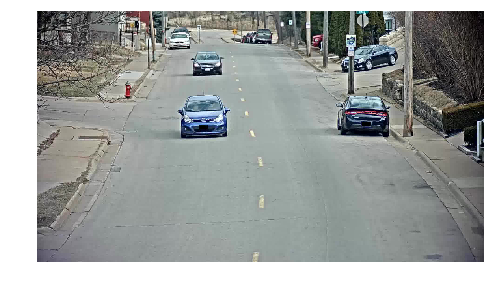

In [0]:
# load and display image
I = io.imread('%s/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
#I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

In [0]:
# load and display instance annotations
# plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
print(anns[0]['bbox'])
bbox = anns[1]['bbox']
overlay = I.copy()
for ann in anns:
  bbox = ann['bbox']
  what=cv2.rectangle(overlay, (int(bbox[0]), int(bbox[1])),
                  (int(bbox[0]+bbox[2]), int(bbox[1]+bbox[3])),
                  (0, 0, 255), 1)
#coco.showAnns(anns)

[596.98, 374.21, 233.05, 190.49]


In [0]:
def cv2_imshow(a):
  """A replacement for cv2.imshow() for use in Jupyter notebooks."""
  a = a.clip(0, 255).astype('uint8')
  # cv2 stores colors as BGR; convert to RGB
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

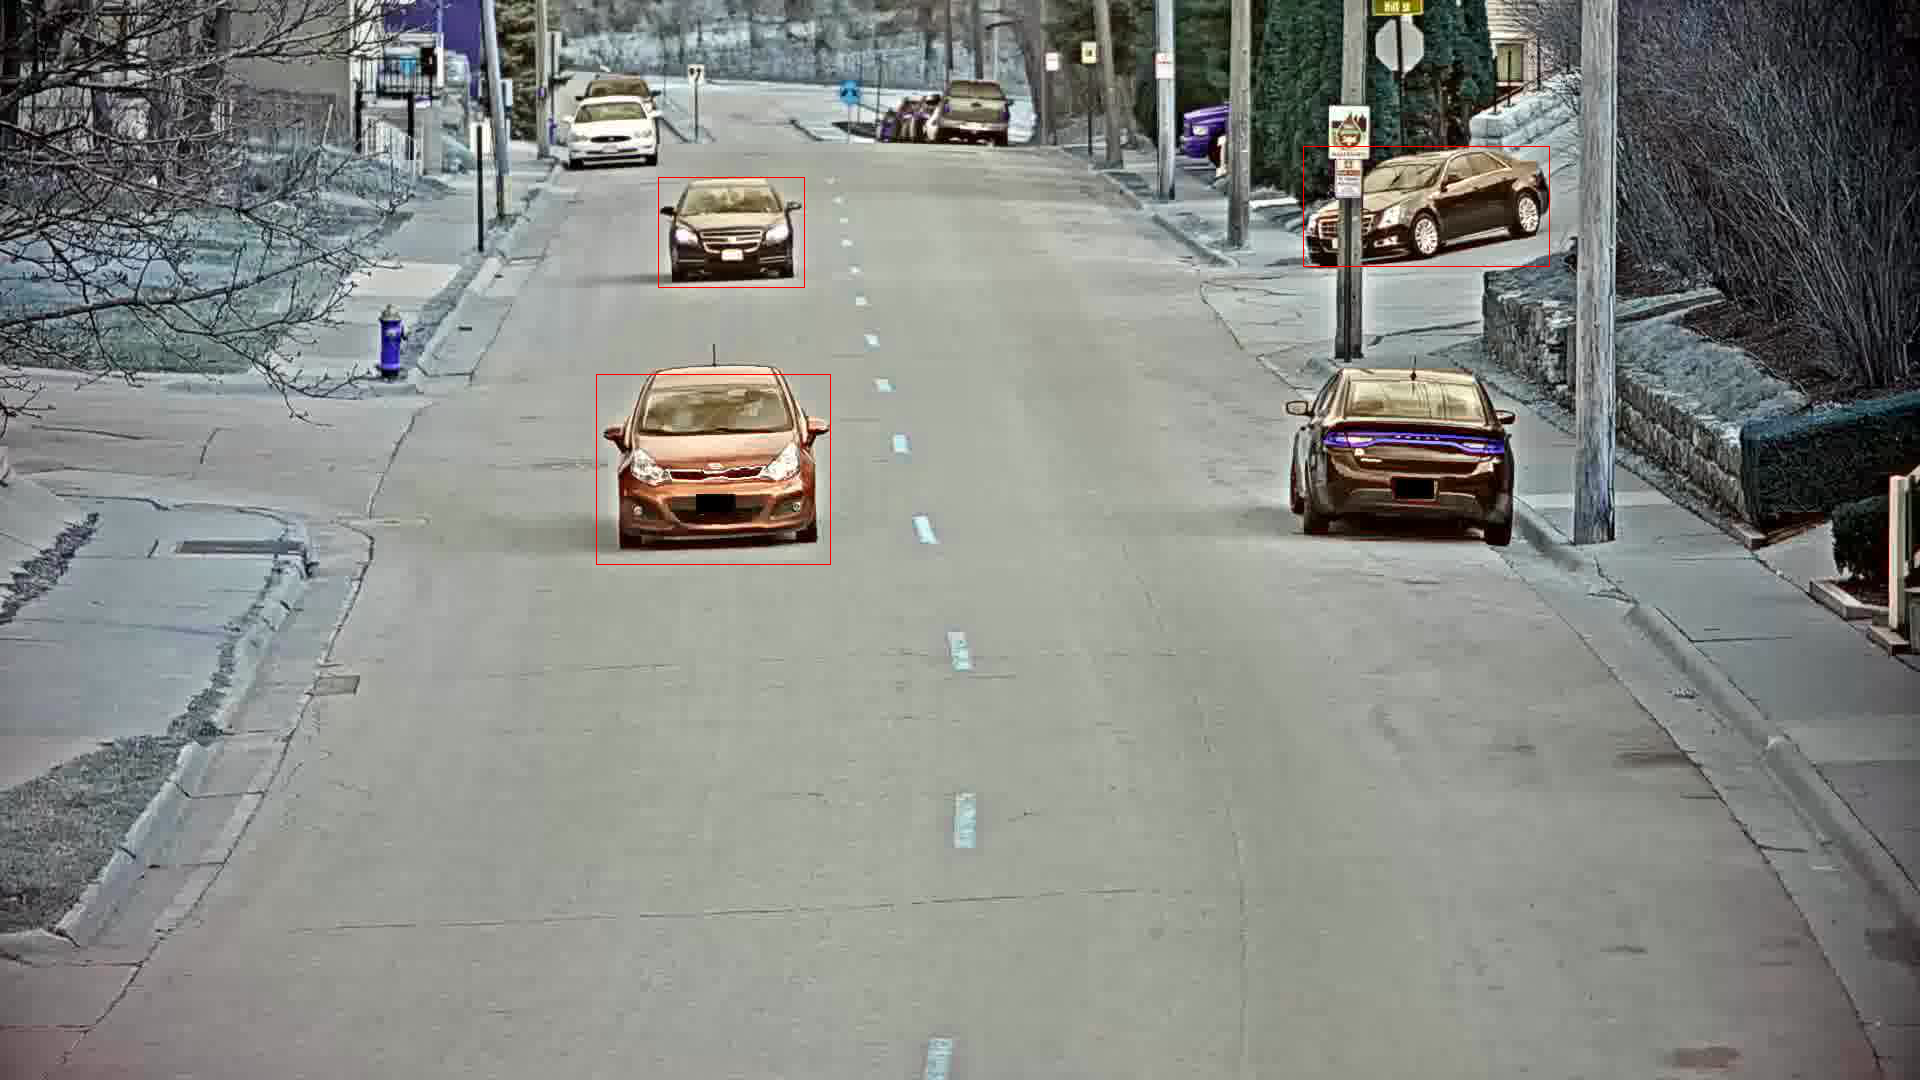

In [0]:
cv2_imshow(what)  # weird colouring due to failed conversion from bgr to rgb or viceversa

So, in principle, the annotations seem to be ok, as we can load and visualize them via the cocoapi.
Moreover, with keras-resnet, we were able to train (although not successfully) with the same annotations.

As a global conclusion, we would need to debug the training script to see where the code silently fails (forward pass or backpropagation, etc.)
We did not keep trying this, since we had three days left to try to fine-tune another model or change being stuck with MaskRCNN until the delivery.